### Libs

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
from pandas.core.computation.pytables import Timedelta

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data loading

In [4]:
df = pd.read_csv('sample_data/df_for_EDA.csv')
df.head(3)

,Kline open time,time,Open price,High price,Low price,Close price,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,1651363200000,2022-05-01 00:00:00,72.57,72.70,72.19,72.22,44042.0,3192083.31,288,16793.0,1217389.99
1,1651366800000,2022-05-01 01:00:00,72.22,72.33,72.00,72.02,31815.0,2294299.05,394,14240.0,1027333.02
2,1651370400000,2022-05-01 02:00:00,72.04,72.14,72.00,72.09,41992.0,3024975.76,279,17690.0,1274526.63


In [5]:
df['time'] = pd.to_datetime(df['time'])
df['diff_time'] = df.time.diff()
df.diff_time.value_counts(dropna=False)

0 days 01:00:00    8812
NaT                   1
0 days 02:00:00       1
0 days 00:00:00       1
Name: diff_time, dtype: int64

In [6]:
# Удаляем дубликат
df.drop_duplicates(subset=['Kline open time'], inplace=True)
# Восстанавливаем пропуск с помощью интерполяции
ti = pd.date_range(start = df.time.min(), end = df.time.max(), freq="1h") # интерполяционная сетка
ts = pd.DataFrame({'date':list(ti)})
ts['unixtime'] = (ts.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
upsampled_Close_price = np.interp(ts.unixtime, df['Kline open time'], df['Close price'])
data = pd.DataFrame({'unixtime': ts.unixtime, 'price': upsampled_Close_price})
data.insert(1, "time", pd.to_datetime(data.unixtime, unit='ms').to_list())
data.drop('unixtime', axis=1, inplace=True)

Text(0, 0.5, 'price')

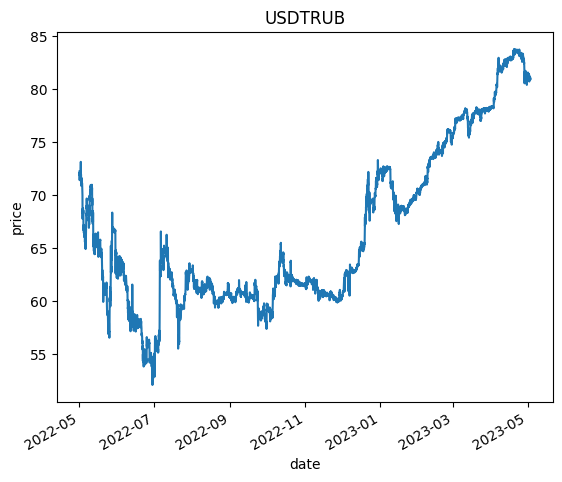

In [7]:
plt.plot(data.time, data.price)
plt.title('USDTRUB')

plt.xticks(rotation=30, ha='right')
plt.xlabel('date')
plt.ylabel('price')

### split data

In [8]:
data_ts = data.time.copy()
data.drop('time', axis=1, inplace=True)

# 1 час оставляем на тест, а трейн и валидацию поделим в соотношении 3 к 1
last_id = data.index.stop
test = data.loc[last_id-1:]
train, val = np.split(data.loc[:last_id-2], [int(.75 *len(data))])
train.shape, val.shape, test.shape

((6611, 1), (2203, 1), (1, 1))

In [9]:

train.index, val.index, test.index

(RangeIndex(start=0, stop=6611, step=1),
 RangeIndex(start=6611, stop=8814, step=1),
 RangeIndex(start=8814, stop=8815, step=1))

### Normalize the data

In [10]:
train_mean = train.mean()
train_std = train.std()

scaled_train = (train - train_mean) / train_std
scaled_val = (val - train_mean) / train_std
scaled_test = (test - train_mean) / train_std
scaled_data = (data - train_mean) / train_std

### dataset generator

In [11]:
# Будем смотреть на прошедшие 24 часов и предсказывать следующий час
n_input=24 
n_features=1
total_window_size = n_input+n_features

BATCH_SIZE = total_window_size

In [12]:
x_train = scaled_train
y_train = scaled_data[n_input:len(train)+n_input] 
x_val = scaled_val[:-n_input]
y_val = scaled_val[n_input:]

In [13]:
# Для модели нужны данные в 3D формате (#batch_size,#inputs,#features)
ds_train = tf.keras.utils.timeseries_dataset_from_array(
        data=np.array(x_train, dtype=np.float32),
        targets=np.array(y_train, dtype=np.float32),
        sequence_length=n_input,
        sequence_stride=1,
        seed = RANDOM_SEED,
        shuffle=False,
        batch_size=BATCH_SIZE)
ds_val = tf.keras.utils.timeseries_dataset_from_array(
        data=np.array(x_val, dtype=np.float32),
        targets=np.array(y_val, dtype=np.float32),
        sequence_length=n_input,
        sequence_stride=1,
        seed = RANDOM_SEED, 
        shuffle=False,
        batch_size=BATCH_SIZE)

In [14]:
for x, y in ds_train.take(1):
  print(x.shape, y.shape)

(25, 24, 1) (25, 1)


### Model

In [15]:
MAX_EPOCHS          = 100
patience            = 5
patience_reduce_lr  = 2
LR                  = 1e-3 # Learning rate

In [16]:
model=Sequential()
model.add(L.LSTM(80,activation='relu', input_shape=(n_input,n_features), bias_regularizer=regularizers.L2(1e-2), kernel_regularizer=regularizers.L2(1e-2), activity_regularizer=regularizers.L2(1e-2), return_sequences=True))
model.add(L.LSTM(20, activation='relu'))
model.add(L.Dense(1))

In [17]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=LR),
                metrics=[tf.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 80)            26240     
                                                                 
 lstm_1 (LSTM)               (None, 20)                8080      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 34,341
Trainable params: 34,341
Non-trainable params: 0
_________________________________________________________________


In [18]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Binance_project/best_model.hdf5', 
                             monitor=['val_loss'], 
                             verbose=0, 
                             mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  restore_best_weights=True,
                                                  mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=patience_reduce_lr, min_lr=0.00001)
callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [19]:
model.fit(ds_train,epochs=MAX_EPOCHS, validation_data=ds_val, callbacks=callbacks_list)

Epoch 1/100
264/264 [==============================] - 27s 72ms/step - loss: 0.9085 - mean_absolute_error: 0.2565 - val_loss: 1.1552 - val_mean_absolute_error: 0.4089 - lr: 0.0010
Epoch 2/100
264/264 [==============================] - 14s 52ms/step - loss: 0.4803 - mean_absolute_error: 0.1118 - val_loss: 0.5766 - val_mean_absolute_error: 0.0407 - lr: 0.0010
Epoch 3/100
264/264 [==============================] - 12s 45ms/step - loss: 0.3076 - mean_absolute_error: 0.1067 - val_loss: 0.3828 - val_mean_absolute_error: 0.0948 - lr: 0.0010
Epoch 4/100
264/264 [==============================] - 9s 35ms/step - loss: 0.1947 - mean_absolute_error: 0.1039 - val_loss: 0.2544 - val_mean_absolute_error: 0.0597 - lr: 0.0010
Epoch 5/100
264/264 [==============================] - 11s 43ms/step - loss: 0.1251 - mean_absolute_error: 0.1044 - val_loss: 0.2916 - val_mean_absolute_error: 0.2865 - lr: 0.0010
Epoch 6/100
264/264 [==============================] - 10s 37ms/step - loss: 0.0846 - mean_absolute_e

In [20]:
model.load_weights('/content/drive/MyDrive/Binance_project/best_model.hdf5')

In [21]:
results = model.evaluate(ds_val)
print(model.metrics_names)
print(results)

87/87 [==============================] - 2s 17ms/step - loss: 0.0727 - mean_absolute_error: 0.1090
['loss', 'mean_absolute_error']
[0.07269882410764694, 0.1090269461274147]


In [22]:
predict = model.predict(ds_val)

87/87 [==============================] - 2s 15ms/step


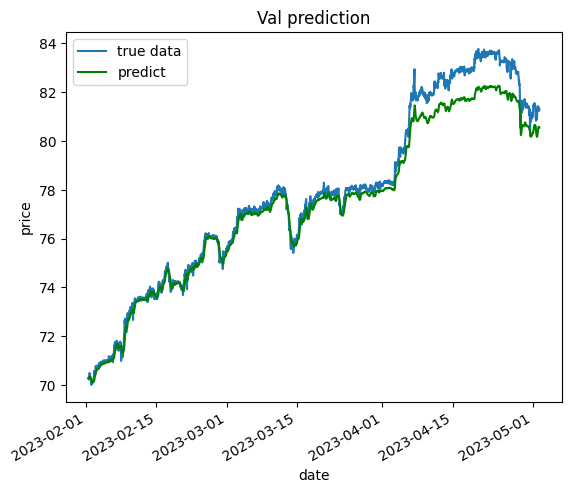

In [23]:
batch_stop = predict.shape[0]
val_result = val.loc[val.index.start+n_input:val.index.stop-val.shape[0]+batch_stop+n_input-1].copy()
val_result['time'] = data_ts.loc[val_result.index]
val_result['predict'] = predict*train_std.price+train_mean.price

plt.plot(val_result.time, val_result.price, label = 'true data')
plt.plot(val_result.time, val_result.predict, color='green', label = 'predict')

plt.title('Val prediction')

plt.xticks(rotation=30, ha='right')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()

In [24]:
# Для теста нам нужны данные на один батч. То есть на 25 выходов.
x_test = scaled_val[-n_input-BATCH_SIZE+1:]
y_test = scaled_val[-BATCH_SIZE+1:]
y_test = pd.concat([y_test, scaled_test])

ds_test = tf.keras.utils.timeseries_dataset_from_array(
        data=np.array(x_test, dtype=np.float32),
        targets=np.array(y_test, dtype=np.float32),
        sequence_length=n_input,
        sequence_stride=1,
        seed = RANDOM_SEED, 
        shuffle=False,
        batch_size=BATCH_SIZE)

In [25]:
test_results = model.evaluate(ds_test)
print(model.metrics_names)
print(test_results)

1/1 [==============================] - 0s 86ms/step - loss: 0.0962 - mean_absolute_error: 0.1649
['loss', 'mean_absolute_error']
[0.09621235728263855, 0.16492639482021332]


In [26]:
predict_test = model.predict(ds_test)

1/1 [==============================] - 0s 79ms/step


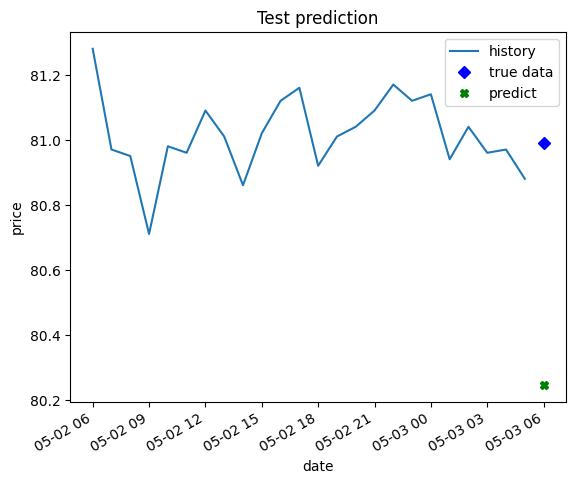

In [27]:
test_history = val.loc[val.index.stop-n_input:].copy()
test_history = pd.concat([test_history, test])
test_history['time'] = data_ts.loc[test_history.index]
test_history['predict'] = 0
test_history.loc[test.index.start,'predict'] = (predict_test[-1:][0][0]*train_std.price+train_mean.price)

plt.plot(test_history.time.iloc[:-1], test_history.price.iloc[:-1], label = 'history')
plt.plot(test_history.time.iloc[-1:], test_history.price.iloc[-1:], "bD", label = 'true data')
plt.plot(test_history.time.iloc[-1:], test_history.predict.iloc[-1:], "gX", label = 'predict')

plt.title('Test prediction')

plt.xticks(rotation=30, ha='right')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()